In [1]:
!pip install pyramid-arima

     |████████████████████████████████| 604kB 8.8MB/s 


In [2]:
import numpy as np
import pandas as pd
import fastai
import re
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from pyramid.arima import auto_arima
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from prettytable import PrettyTable

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr

In [3]:
df = pd.read_csv('/content/drive/MyDrive/G.Barekat.Pharm.csv')
df.head()

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,G.Barekat.Pharm,20210207,21220.0,22160.0,21220.0,21950.0,430478691670,19611390,5166,D,21110.0,22160.0
1,G.Barekat.Pharm,20210206,22000.0,22100.0,20810.0,21110.0,1116507854150,52895611,11783,D,21900.0,20810.0
2,G.Barekat.Pharm,20210203,22560.0,22560.0,20600.0,21900.0,3368892543720,153814430,37756,D,21490.0,22060.0
3,G.Barekat.Pharm,20210202,21490.0,21490.0,21490.0,21490.0,105340563090,4901841,1984,D,20470.0,21490.0
4,G.Barekat.Pharm,20210201,20000.0,20620.0,19640.0,20470.0,606821827820,29648144,8390,D,19640.0,20620.0


In [4]:
query = pd.read_csv('/content/drive/MyDrive/test.csv', nrows= 1)
query.head()

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,G.Barekat.Pharm,20210208,23040,23040,22000,22810,1.809780e+12,79334852,23633,D,21950,23040


In [5]:
df.shape

(921, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <TICKER>      921 non-null    object 
 1   <DTYYYYMMDD>  921 non-null    int64  
 2   <FIRST>       921 non-null    float64
 3   <HIGH>        921 non-null    float64
 4   <LOW>         921 non-null    float64
 5   <CLOSE>       921 non-null    float64
 6   <VALUE>       921 non-null    int64  
 7   <VOL>         921 non-null    int64  
 8   <OPENINT>     921 non-null    int64  
 9   <PER>         921 non-null    object 
 10  <OPEN>        921 non-null    float64
 11  <LAST>        921 non-null    float64
dtypes: float64(6), int64(4), object(2)
memory usage: 86.5+ KB


In [7]:
df.any().isnull()

<TICKER>        False
<DTYYYYMMDD>    False
<FIRST>         False
<HIGH>          False
<LOW>           False
<CLOSE>         False
<VALUE>         False
<VOL>           False
<OPENINT>       False
<PER>           False
<OPEN>          False
<LAST>          False
dtype: bool

In [8]:
df['<PER>'].value_counts()

D    921
Name: <PER>, dtype: int64

In [9]:
sorted(df['<PER>'].unique())

['D']

In [10]:
df.drop(['<TICKER>','<PER>'], axis= 1, inplace= True)
df['<VALUE>'] = df['<VALUE>'].astype('float64')
df['<DATE>']= pd.to_datetime(df['<DTYYYYMMDD>'], format='%Y%m%d', errors='coerce')
df.drop(['<DTYYYYMMDD>'], axis= 1, inplace= True)
df.head()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<OPEN>,<LAST>,<DATE>
0,21220.0,22160.0,21220.0,21950.0,4.304787e+11,19611390,5166,21110.0,22160.0,2021-02-07
1,22000.0,22100.0,20810.0,21110.0,1.116508e+12,52895611,11783,21900.0,20810.0,2021-02-06
2,22560.0,22560.0,20600.0,21900.0,3.368893e+12,153814430,37756,21490.0,22060.0,2021-02-03
3,21490.0,21490.0,21490.0,21490.0,1.053406e+11,4901841,1984,20470.0,21490.0,2021-02-02
4,20000.0,20620.0,19640.0,20470.0,6.068218e+11,29648144,8390,19640.0,20620.0,2021-02-01


In [11]:
query.drop(['<TICKER>','<PER>'], axis= 1, inplace= True)
query['<VALUE>'] = query['<VALUE>'].astype('float64')
query['<DATE>']= pd.to_datetime(query['<DTYYYYMMDD>'], format='%Y%m%d', errors='coerce')
query.drop(['<DTYYYYMMDD>'], axis= 1, inplace= True)
query.head()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<OPEN>,<LAST>,<DATE>
0,23040,23040,22000,22810,1.809780e+12,79334852,23633,21950,23040,2021-02-08


In [12]:
df['<PROFIT>'] = df['<CLOSE>'] - df['<OPEN>']
df['label'] = 0

for i in range(0,len(df)):
  if (df['<PROFIT>'][i]>= 0):
    df['label'][i] = 1

df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<OPEN>,<LAST>,<DATE>,<PROFIT>,label
0,21220.0,22160.0,21220.0,21950.0,4.304787e+11,19611390,5166,21110.0,22160.0,2021-02-07,840.0,1
1,22000.0,22100.0,20810.0,21110.0,1.116508e+12,52895611,11783,21900.0,20810.0,2021-02-06,-790.0,0
2,22560.0,22560.0,20600.0,21900.0,3.368893e+12,153814430,37756,21490.0,22060.0,2021-02-03,410.0,1
3,21490.0,21490.0,21490.0,21490.0,1.053406e+11,4901841,1984,20470.0,21490.0,2021-02-02,1020.0,1
4,20000.0,20620.0,19640.0,20470.0,6.068218e+11,29648144,8390,19640.0,20620.0,2021-02-01,830.0,1
5,19840.0,19840.0,18900.0,19640.0,1.641516e+12,83592610,23106,18900.0,19840.0,2021-01-31,740.0,1
6,18220.0,19010.0,18150.0,18900.0,1.135648e+12,60079425,13518,18110.0,19010.0,2021-01-30,790.0,1
7,18030.0,18800.0,18030.0,18110.0,1.153420e+12,63688055,14150,18970.0,18030.0,2021-01-27,-860.0,0
8,19230.0,19800.0,18900.0,18970.0,6.138901e+11,32364143,7929,19890.0,18900.0,2021-01-26,-920.0,0
9,19520.0,20900.0,19470.0,19890.0,1.469934e+12,73904888,20571,20490.0,19470.0,2021-01-25,-600.0,0


In [13]:
query['<PROFIT>'] = query['<CLOSE>'] - query['<OPEN>']
query['label'] = 0

if (query['<PROFIT>'][0]>= 0):
    query['label'][0] = 1

query.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<OPEN>,<LAST>,<DATE>,<PROFIT>,label
0,23040,23040,22000,22810,1.809780e+12,79334852,23633,21950,23040,2021-02-08,860,1


In [14]:
df['label'].value_counts()

0    475
1    446
Name: label, dtype: int64

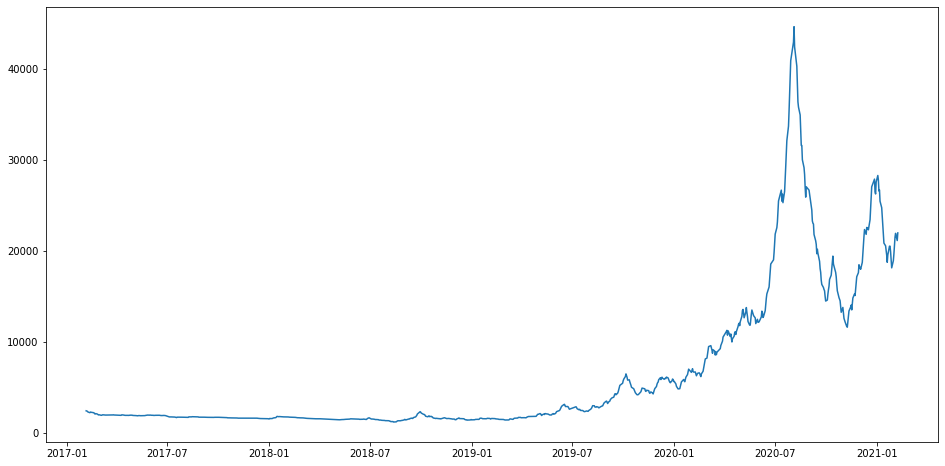

In [15]:
#setting figure size
rcParams['figure.figsize'] = 20,10

#setting index as date
df.index = df['<DATE>']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['<CLOSE>'], label='Close Price history')

In [16]:
#sorting
df= df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['<DATE>','<CLOSE>','<OPEN>','label'])

for i in range(0,len(df)):
     new_data['<DATE>'][i] = df['<DATE>'][i]
     new_data['<OPEN>'][i] = df['<OPEN>'][i]
     new_data['<CLOSE>'][i] = df['<CLOSE>'][i]
     new_data['label'][i] = df['label'][i]

new_data     

,<DATE>,<CLOSE>,<OPEN>,label
0,2017-02-05 00:00:00,2401,1000,1
1,2017-02-06 00:00:00,2380,2401,0
2,2017-02-07 00:00:00,2355,2380,0
3,2017-02-08 00:00:00,2282,2355,0
4,2017-02-11 00:00:00,2209,2282,0
...,...,...,...,...
916,2021-02-01 00:00:00,20470,19640,1
917,2021-02-02 00:00:00,21490,20470,1
918,2021-02-03 00:00:00,21900,21490,1
919,2021-02-06 00:00:00,21110,21900,0


In [17]:
#creating a separate dataset
copy_query = pd.DataFrame(index=range(0,len(query)),columns=['<DATE>','<CLOSE>','<OPEN>','label'])

copy_query['<DATE>'][0] = query['<DATE>'][0]
copy_query['<OPEN>'][0] = query['<OPEN>'][0]
copy_query['<CLOSE>'][0] = query['<CLOSE>'][0]
copy_query['label'][0] = query['label'][0]

copy_query 

,<DATE>,<CLOSE>,<OPEN>,label
0,2021-02-08 00:00:00,22810,21950,1


In [18]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [19]:
#create features
add_datepart(new_data, '<DATE>')
new_data.columns = ['Close', 'Open', 'Label' , 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 
                    'Dayofyear', 'Is_month_end', 'Is_month_start', 
                    'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
                    'Is_year_start', 'Elapsed']

new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp 

new_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2401,1000,1,2017,2,5,5,6,36,False,False,False,False,False,False
1,2380,2401,0,2017,2,6,6,0,37,False,False,False,False,False,False
2,2355,2380,0,2017,2,6,7,1,38,False,False,False,False,False,False
3,2282,2355,0,2017,2,6,8,2,39,False,False,False,False,False,False
4,2209,2282,0,2017,2,6,11,5,42,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,20470,19640,1,2021,2,5,1,0,32,False,True,False,False,False,False
917,21490,20470,1,2021,2,5,2,1,33,False,False,False,False,False,False
918,21900,21490,1,2021,2,5,3,2,34,False,False,False,False,False,False
919,21110,21900,0,2021,2,5,6,5,37,False,False,False,False,False,False


In [20]:
#create features
add_datepart(copy_query, '<DATE>')
copy_query.columns = ['Close', 'Open', 'Label' , 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 
                    'Dayofyear', 'Is_month_end', 'Is_month_start', 
                    'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
                    'Is_year_start', 'Elapsed']

copy_query.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp 

copy_query

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,22810,21950,1,2021,2,6,8,0,39,False,False,False,False,False,False


In [21]:
#split into train and validation
train = new_data[:663]
valid = new_data[663:]

In [22]:
train

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2401,1000,1,2017,2,5,5,6,36,False,False,False,False,False,False
1,2380,2401,0,2017,2,6,6,0,37,False,False,False,False,False,False
2,2355,2380,0,2017,2,6,7,1,38,False,False,False,False,False,False
3,2282,2355,0,2017,2,6,8,2,39,False,False,False,False,False,False
4,2209,2282,0,2017,2,6,11,5,42,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,5486,5558,0,2019,12,52,25,2,359,False,False,False,False,False,False
659,5705,5486,1,2019,12,52,28,5,362,False,False,False,False,False,False
660,5897,5705,1,2019,12,52,29,6,363,False,False,False,False,False,False
661,5827,5897,0,2019,12,1,30,0,364,False,False,False,False,False,False


In [23]:
valid

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
663,5634,5626,1,2020,1,1,1,2,1,False,True,False,True,False,True
664,5353,5634,0,2020,1,1,4,5,4,False,False,False,False,False,False
665,5093,5353,0,2020,1,1,5,6,5,False,False,False,False,False,False
666,4905,5093,0,2020,1,2,7,1,7,False,False,False,False,False,False
667,4807,4905,0,2020,1,2,8,2,8,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,20470,19640,1,2021,2,5,1,0,32,False,True,False,False,False,False
917,21490,20470,1,2021,2,5,2,1,33,False,False,False,False,False,False
918,21900,21490,1,2021,2,5,3,2,34,False,False,False,False,False,False
919,21110,21900,0,2021,2,5,6,5,37,False,False,False,False,False,False


In [24]:
y_train = train['Close']
y_valid = valid['Close']

x_train = train.drop(['Label','Open','Close'], axis= 1)
x_valid = valid.drop(['Label','Open', 'Close'], axis= 1)

In [25]:
y_query = copy_query['Close']
x_query = copy_query.drop(['Label','Open','Close'], axis= 1)

In [26]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

15680.11523886393

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



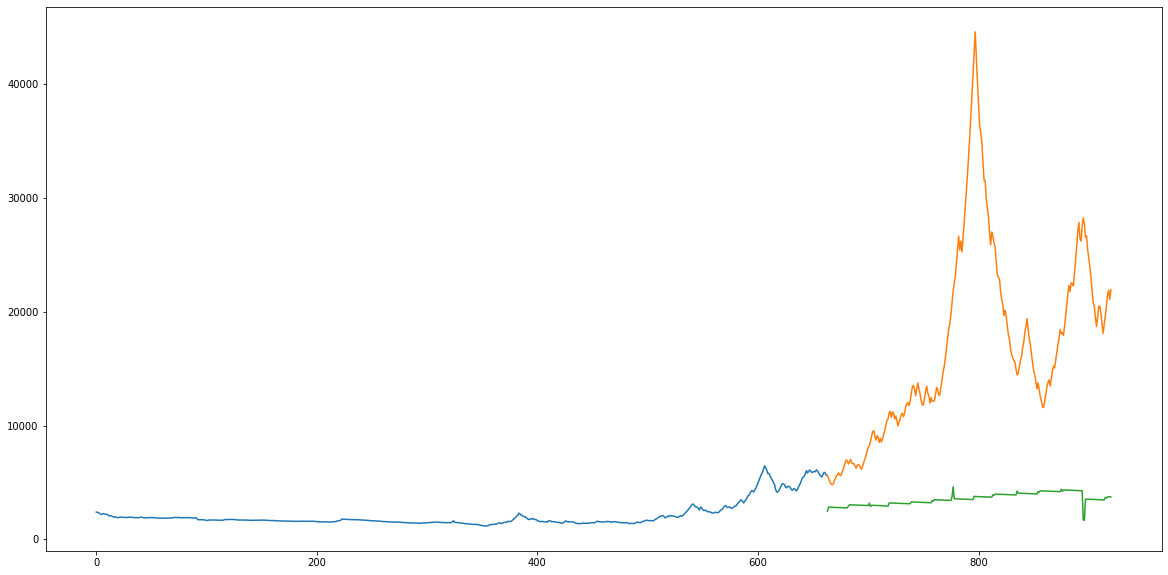

In [28]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

train.index = new_data[:663].index
valid.index = new_data[663:].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

In [29]:
valid['Predicted Profit'] = valid['Predictions'] - valid['Open']
valid['Predicted Labels'] = 0

for i in range(663,921):
  if (valid['Predicted Profit'][i]>= 0):
    valid['Predicted Labels'][i] = 1

valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
663,5634,5626,1,2020,1,1,1,2,1,False,True,False,True,False,True,2473.471492,-3152.53,0
664,5353,5634,0,2020,1,1,4,5,4,False,False,False,False,False,False,2834.309925,-2799.69,0
665,5093,5353,0,2020,1,1,5,6,5,False,False,False,False,False,False,2832.090989,-2520.91,0
666,4905,5093,0,2020,1,2,7,1,7,False,False,False,False,False,False,2824.178732,-2268.82,0
667,4807,4905,0,2020,1,2,8,2,8,False,False,False,False,False,False,2821.959796,-2083.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,20470,19640,1,2021,2,5,1,0,32,False,True,False,False,False,False,3619.785104,-16020.2,0
917,21490,20470,1,2021,2,5,2,1,33,False,False,False,False,False,False,3745.421077,-16724.6,0
918,21900,21490,1,2021,2,5,3,2,34,False,False,False,False,False,False,3743.202141,-17746.8,0
919,21110,21900,0,2021,2,5,6,5,37,False,False,False,False,False,False,3736.545334,-18163.5,0


In [30]:
true_labels = valid['Label'].values.tolist()
pred_labels = valid['Predicted Labels'].values.tolist()

In [31]:
print(confusion_matrix(true_labels, pred_labels))

[[115   0]
 [143   0]]


In [32]:
acc = accuracy_score(true_labels, pred_labels)
print(acc)

0.44573643410852715


In [33]:
copy_query['Predictions'] = model.predict(x_query)
copy_query['Predicted Profit'] = copy_query['Predictions'] - copy_query['Open'] 
copy_query['Predicted Labels'] = 0

if (copy_query['Predicted Profit'][0]>= 0):
  copy_query['Predicted Labels'][0] = 1

copy_query

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
0,22810,21950,1,2021,2,6,8,0,39,False,False,False,False,False,False,3728.633077,-18221.4,0


In [34]:
y_query_pred = copy_query['Predicted Labels'].values.tolist()
y_query = y_query.values.tolist()
acc = accuracy_score(y_query, y_query_pred)
print(acc)

0.0


In [35]:
#for normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))

x_train[x_train.columns]= scaler.fit_transform(x_train[x_train.columns])
x_valid[x_valid.columns]= scaler.fit_transform(x_valid[x_valid.columns])

In [36]:
x_train

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,0.0,0.090909,0.078431,0.133333,1.000000,0.096154,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.090909,0.098039,0.166667,0.000000,0.098901,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.090909,0.098039,0.200000,0.166667,0.101648,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.090909,0.098039,0.233333,0.333333,0.104396,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.090909,0.098039,0.333333,0.833333,0.112637,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
658,1.0,1.000000,1.000000,0.800000,0.333333,0.983516,0.0,0.0,0.0,0.0,0.0,0.0
659,1.0,1.000000,1.000000,0.900000,0.833333,0.991758,0.0,0.0,0.0,0.0,0.0,0.0
660,1.0,1.000000,1.000000,0.933333,1.000000,0.994505,0.0,0.0,0.0,0.0,0.0,0.0
661,1.0,1.000000,0.000000,0.966667,0.000000,0.997253,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
x_query[x_query.columns]= scaler.fit_transform(x_query[x_query.columns])
x_query

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [39]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

17360.72958930206

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



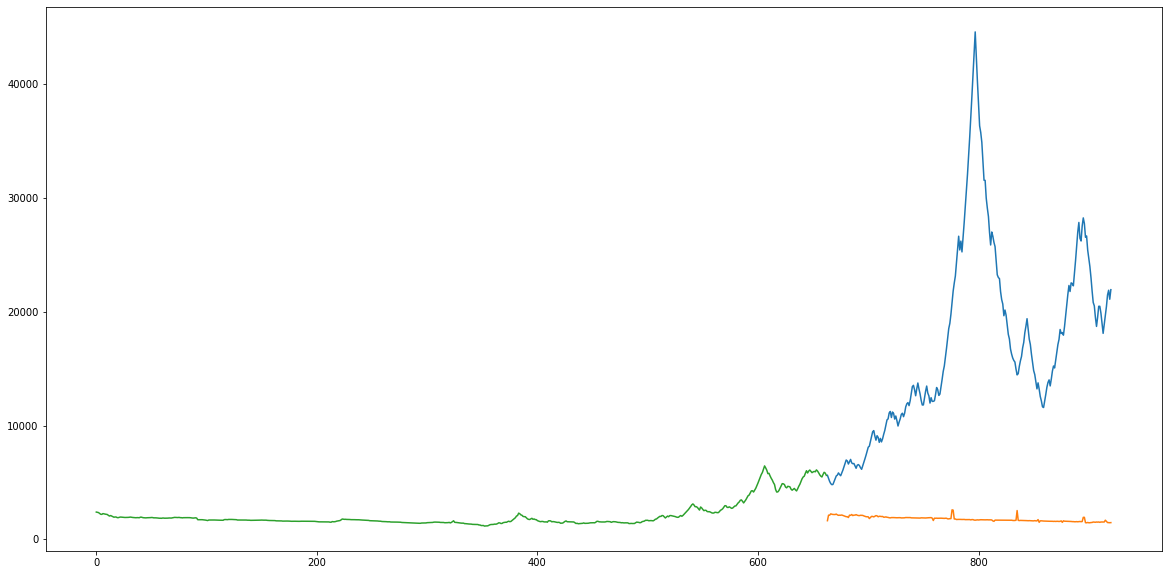

In [40]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

In [41]:
valid['Predicted Profit'] = valid['Predictions'] - valid['Open']
valid['Predicted Labels'] = 0

for i in range(663,921):
  if (valid['Predicted Profit'][i]>= 0):
    valid['Predicted Labels'][i] = 1

valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
663,5634,5626,1,2020,1,1,1,2,1,False,True,False,True,False,True,1642.6,-3983.4,0
664,5353,5634,0,2020,1,1,4,5,4,False,False,False,False,False,False,2126.2,-3507.8,0
665,5093,5353,0,2020,1,1,5,6,5,False,False,False,False,False,False,2126.2,-3226.8,0
666,4905,5093,0,2020,1,2,7,1,7,False,False,False,False,False,False,2244,-2849,0
667,4807,4905,0,2020,1,2,8,2,8,False,False,False,False,False,False,2210.2,-2694.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,20470,19640,1,2021,2,5,1,0,32,False,True,False,False,False,False,1578.4,-18061.6,0
917,21490,20470,1,2021,2,5,2,1,33,False,False,False,False,False,False,1479.8,-18990.2,0
918,21900,21490,1,2021,2,5,3,2,34,False,False,False,False,False,False,1472.4,-20017.6,0
919,21110,21900,0,2021,2,5,6,5,37,False,False,False,False,False,False,1464,-20436,0


In [42]:
true_labels = valid['Label'].values.tolist()
pred_labels = valid['Predicted Labels'].values.tolist()

In [43]:
print(confusion_matrix(true_labels, pred_labels))

[[115   0]
 [143   0]]


In [44]:
acc = accuracy_score(true_labels, pred_labels)
acc

0.44573643410852715

In [45]:
copy_query['Predictions'] = model.predict(x_query)
copy_query['Predicted Profit'] = copy_query['Predictions'] - copy_query['Open'] 
copy_query['Predicted Labels'] = 0

if (copy_query['Predicted Profit'][0]>= 0):
  copy_query['Predicted Labels'][0] = 1

copy_query

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
0,22810,21950,1,2021,2,6,8,0,39,False,False,False,False,False,False,2184.8,-19765.2,0


In [46]:
y_query_pred = copy_query['Predicted Labels'].values.tolist()
acc = accuracy_score(y_query, y_query_pred)
print(acc)

0.0


In [47]:
df.columns = ['First', 'High', 'Low' , 'Close', 'Value', 'Vol', 'Openint', 
              'Open', 'Last', 'Date', 'Profit', 'Label']

In [48]:
query.columns = ['First', 'High', 'Low' , 'Close', 'Value', 'Vol', 'Openint', 
              'Open', 'Last', 'Date', 'Profit', 'Label']

In [49]:
#split into train and validation
training = (df[:663])['Close']
validation = (df[663:])['Close']

In [50]:
validation

<DATE>
2020-01-01     5634.0
2020-01-04     5353.0
2020-01-05     5093.0
2020-01-07     4905.0
2020-01-08     4807.0
               ...   
2021-02-01    20470.0
2021-02-02    21490.0
2021-02-03    21900.0
2021-02-06    21110.0
2021-02-07    21950.0
Name: Close, Length: 258, dtype: float64

In [51]:
model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12
                   ,start_P=0, seasonal=True,d=1, D=1, 
                   trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)
forecast = model.predict(n_periods=259)
forecast = pd.DataFrame(forecast,index = range(663, 922),columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7271.201, BIC=7293.586, Fit time=4.503 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=7916.985, BIC=7925.939, Fit time=0.087 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=7497.609, BIC=7515.517, Fit time=2.131 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7293.672, BIC=7311.580, Fit time=3.237 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=7271.686, BIC=7298.548, Fit time=6.336 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=7678.585, BIC=7696.493, Fit time=0.591 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=7271.514, BIC=7298.376, Fit time=13.046 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=7272.050, BIC=7303.389, Fit time=23.602 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7268.005, BIC=7294.867, Fit time=7.824 seconds
Fit ARIMA: order=(2, 1, 0)

In [52]:
copy_query['Predictions'] = forecast.tail(1).values
forecast.drop(forecast.tail(1).index,inplace=True) 

In [53]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

11106.315881395603

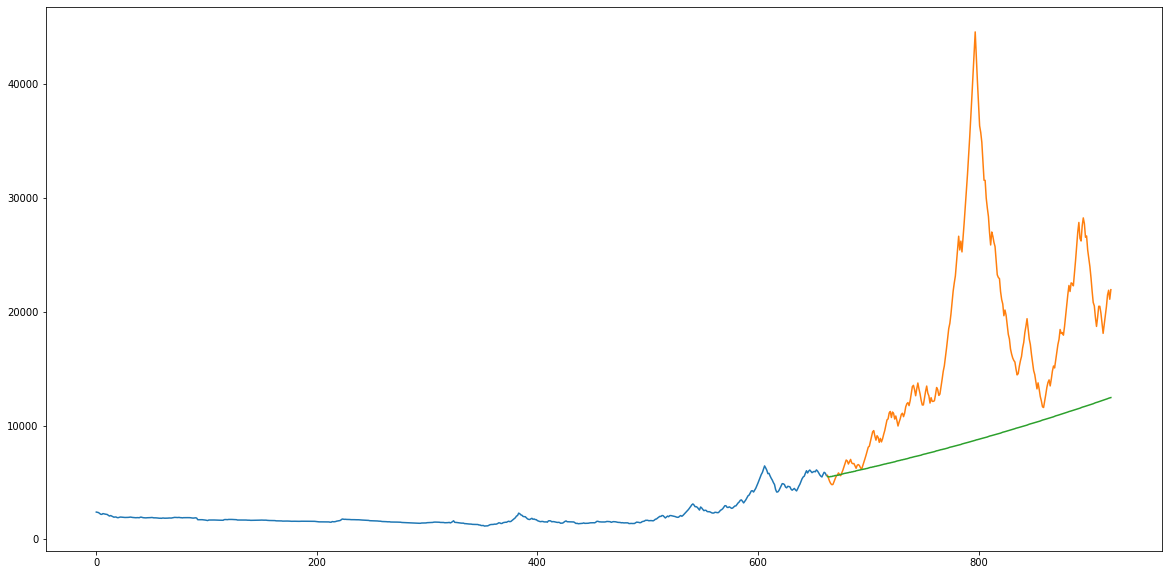

In [54]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [55]:
valid['Predictions'] = forecast['Prediction']
valid['Predicted Profit'] = valid['Predictions'] - valid['Open']
valid['Predicted Labels'] = 0

for i in range(663,921):
  if (valid['Predicted Profit'][i]>= 0):
    valid['Predicted Labels'][i] = 1

valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
663,5634,5626,1,2020,1,1,1,2,1,False,True,False,True,False,True,5529.969368,-96.0306,0
664,5353,5634,0,2020,1,1,4,5,4,False,False,False,False,False,False,5503.904139,-130.096,0
665,5093,5353,0,2020,1,1,5,6,5,False,False,False,False,False,False,5493.246998,140.247,1
666,4905,5093,0,2020,1,2,7,1,7,False,False,False,False,False,False,5529.084389,436.084,1
667,4807,4905,0,2020,1,2,8,2,8,False,False,False,False,False,False,5524.587655,619.588,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,20470,19640,1,2021,2,5,1,0,32,False,True,False,False,False,False,12319.795733,-7320.2,0
917,21490,20470,1,2021,2,5,2,1,33,False,False,False,False,False,False,12366.352445,-8103.65,0
918,21900,21490,1,2021,2,5,3,2,34,False,False,False,False,False,False,12407.652495,-9082.35,0
919,21110,21900,0,2021,2,5,6,5,37,False,False,False,False,False,False,12434.370298,-9465.63,0


In [56]:
true_labels = valid['Label'].values.tolist()
pred_labels = valid['Predicted Labels'].values.tolist()

In [57]:
print(confusion_matrix(true_labels, pred_labels))

[[112   3]
 [137   6]]


In [58]:
acc = accuracy_score(true_labels, pred_labels)
acc

0.4573643410852713

In [59]:
copy_query['Predicted Profit'] = copy_query['Predictions'] - copy_query['Open'] 
copy_query['Predicted Labels'] = 0

if (copy_query['Predicted Profit'][0]>= 0):
  copy_query['Predicted Labels'][0] = 1

copy_query

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
0,22810,21950,1,2021,2,6,8,0,39,False,False,False,False,False,False,12499.308062,-9450.69,0


In [60]:
y_query_pred = copy_query['Predicted Labels'].values.tolist()
acc = accuracy_score(y_query, y_query_pred)
print(acc)

0.0


In [61]:
#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['Close'][i] = df['Close'][i]

new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

new_data

,ds,y
Date,,
2017-02-05,2017-02-05 00:00:00,2401
2017-02-06,2017-02-06 00:00:00,2380
2017-02-07,2017-02-07 00:00:00,2355
2017-02-08,2017-02-08 00:00:00,2282
2017-02-11,2017-02-11 00:00:00,2209
...,...,...
2021-02-01,2021-02-01 00:00:00,20470
2021-02-02,2021-02-02 00:00:00,21490
2021-02-03,2021-02-03 00:00:00,21900


In [62]:
#creating dataframe
copy_query = pd.DataFrame(index=range(0,len(query)),columns=['Date', 'Close'])

copy_query['Date'][0] = query['Date'][0]
copy_query['Close'][0] = query['Close'][0]

copy_query.index = copy_query['Date']
 
#preparing data
copy_query.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

copy_query

,ds,y
Date,,
2021-02-08,2021-02-08 00:00:00,22810


In [63]:
#train and validation
training = new_data[:663]
validation = new_data[663:]

In [64]:
x_query = copy_query
x_query

,ds,y
Date,,
2021-02-08,2021-02-08 00:00:00,22810


In [65]:
#fit the model
model = Prophet()
model.fit(training)

#predictions
close_prices = model.make_future_dataframe(periods=len(validation)+1)
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [66]:
#rmse
forecast_valid = forecast['yhat'][663:921]
copy_query['Predictions'] = forecast['yhat'][921:].values
rms=np.sqrt(np.mean(np.power((np.array(validation['y'])-np.array(forecast_valid)),2)))
rms

11858.1901078596

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

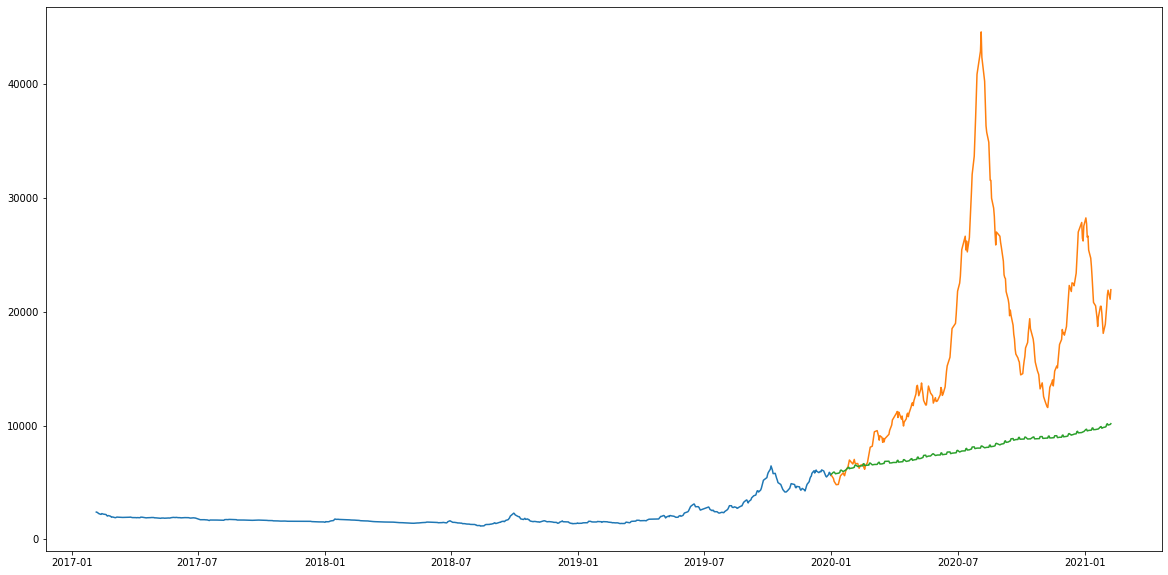

In [67]:
#plot
validation['Predictions'] = 0
valid['Predictions'] = forecast_valid.values
validation['Predictions'] = forecast_valid.values

plt.plot(training['y'])
plt.plot(validation[['y', 'Predictions']])

In [68]:
valid['Predicted Profit'] = valid['Predictions'] - valid['Open']
valid['Predicted Labels'] = 0

for i in range(663,921):
  if (valid['Predicted Profit'][i]>= 0):
    valid['Predicted Labels'][i] = 1

valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
663,5634,5626,1,2020,1,1,1,2,1,False,True,False,True,False,True,5727.233207,101.233,1
664,5353,5634,0,2020,1,1,4,5,4,False,False,False,False,False,False,5904.355010,270.355,1
665,5093,5353,0,2020,1,1,5,6,5,False,False,False,False,False,False,5918.193206,565.193,1
666,4905,5093,0,2020,1,2,7,1,7,False,False,False,False,False,False,5766.622760,673.623,1
667,4807,4905,0,2020,1,2,8,2,8,False,False,False,False,False,False,5785.489777,880.49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,20470,19640,1,2021,2,5,1,0,32,False,True,False,False,False,False,10118.207313,-9521.79,0
917,21490,20470,1,2021,2,5,2,1,33,False,False,False,False,False,False,10165.635119,-10304.4,0
918,21900,21490,1,2021,2,5,3,2,34,False,False,False,False,False,False,10048.494677,-11441.5,0
919,21110,21900,0,2021,2,5,6,5,37,False,False,False,False,False,False,10102.448051,-11797.6,0


In [69]:
true_labels = valid['Label'].values.tolist()
pred_labels = valid['Predicted Labels'].values.tolist()

In [70]:
print(confusion_matrix(true_labels, pred_labels))

[[106   9]
 [130  13]]


In [71]:
acc = accuracy_score(true_labels, pred_labels)
acc

0.46124031007751937

In [72]:
copy_query

,ds,y,Predictions
Date,,,
2021-02-08,2021-02-08 00:00:00,22810,10232.750503


In [73]:
copy_query['Predicted Profit'] = copy_query['Predictions'] - query['Open'].values 
copy_query['Predicted Labels'] = 0

if (copy_query['Predicted Profit'][0]>= 0):
  copy_query['Predicted Labels'][0] = 1

copy_query

,ds,y,Predictions,Predicted Profit,Predicted Labels
Date,,,,,
2021-02-08,2021-02-08 00:00:00,22810,10232.750503,-11717.249497,0


In [74]:
y_query_pred = copy_query['Predicted Labels'].values.tolist()
acc = accuracy_score(y_query, y_query_pred)
print(acc)

0.0


In [75]:
new_data.rename(columns={'y': 'Close', 'ds': 'Date'}, inplace=True)
new_data.drop('Date', axis=1, inplace=True)

copy_query.rename(columns={'y': 'Close', 'ds': 'Date'}, inplace=True)
copy_query.drop(['Date', 'Predictions', 'Predicted Profit', 'Predicted Labels'], axis=1, inplace=True)

In [85]:
new_data = new_data.append(copy_query)

#creating train and test sets
dataset = new_data.values

training = dataset[0:663,:]
validation = dataset[663:,:]

In [86]:
training.shape

(663, 1)

In [87]:
validation.shape

(259, 1)

In [88]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(training)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [89]:
x_train.shape

(603, 60, 1)

In [90]:
y_train.shape

(603,)

In [91]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [92]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

603/603 - 16s - loss: 1.8088e-04


In [93]:
#predicting 258 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(validation) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [94]:
closing_price.shape

(259, 1)

In [110]:
training = new_data[:663]
validation = new_data[663:921]
copy_query['Predictions'] = closing_price[-1]

In [112]:
rms=np.sqrt(np.mean(np.power(((validation-closing_price[:-1]).values),2)))
rms

3756.635371665776

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



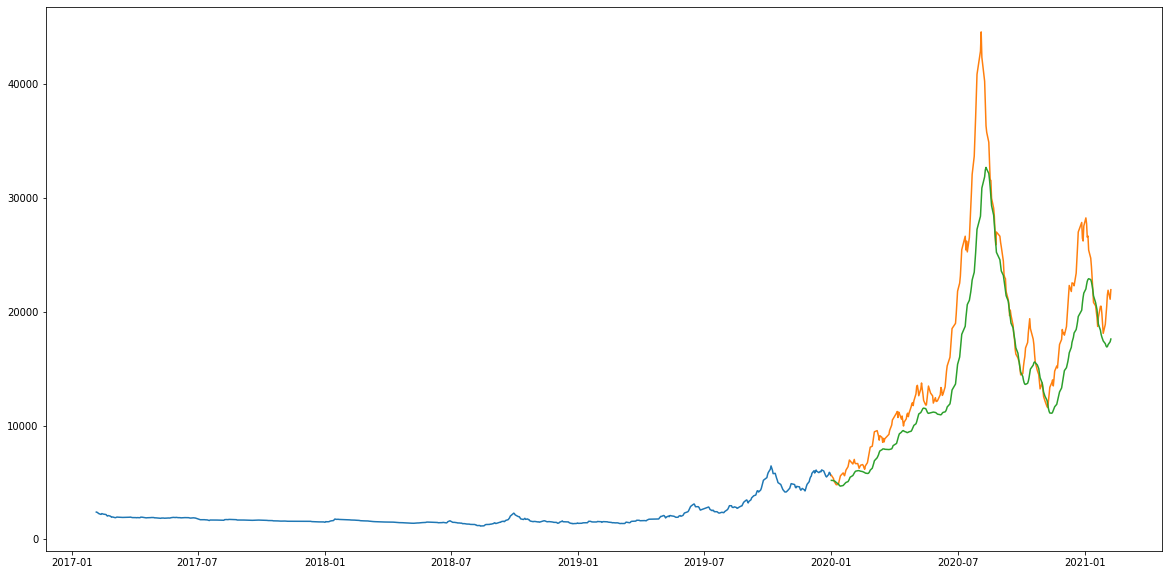

In [113]:
#for plotting

validation['Predictions'] = closing_price[:-1]
valid['Predictions'] = closing_price[:-1]
plt.plot(training['Close'])
plt.plot(validation[['Close','Predictions']])

In [114]:
valid['Predicted Profit'] = valid['Predictions'] - valid['Open']
valid['Predicted Labels'] = 0

for i in range(663,921):
  if (valid['Predicted Profit'][i]>= 0):
    valid['Predicted Labels'][i] = 1

valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,Close,Open,Label,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Predictions,Predicted Profit,Predicted Labels
663,5634,5626,1,2020,1,1,1,2,1,False,True,False,True,False,True,5187.403320,-438.597,0
664,5353,5634,0,2020,1,1,4,5,4,False,False,False,False,False,False,5172.762207,-461.238,0
665,5093,5353,0,2020,1,1,5,6,5,False,False,False,False,False,False,5138.027832,-214.972,0
666,4905,5093,0,2020,1,2,7,1,7,False,False,False,False,False,False,5075.735840,-17.2642,0
667,4807,4905,0,2020,1,2,8,2,8,False,False,False,False,False,False,4988.807129,83.8071,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,20470,19640,1,2021,2,5,1,0,32,False,True,False,False,False,False,16916.318359,-2723.68,0
917,21490,20470,1,2021,2,5,2,1,33,False,False,False,False,False,False,16942.755859,-3527.24,0
918,21900,21490,1,2021,2,5,3,2,34,False,False,False,False,False,False,17110.982422,-4379.02,0
919,21110,21900,0,2021,2,5,6,5,37,False,False,False,False,False,False,17374.845703,-4525.15,0


In [115]:
true_labels = valid['Label'].values.tolist()
pred_labels = valid['Predicted Labels'].values.tolist()

In [116]:
print(confusion_matrix(true_labels, pred_labels))

[[105  10]
 [140   3]]


In [117]:
acc = accuracy_score(true_labels, pred_labels)
acc

0.4186046511627907

In [118]:
copy_query['Predicted Profit'] = copy_query['Predictions'] - query['Open'].values 
copy_query['Predicted Labels'] = 0

if (copy_query['Predicted Profit'][0]>= 0):
  copy_query['Predicted Labels'][0] = 1

copy_query

,Close,Predictions,Predicted Profit,Predicted Labels
Date,,,,
2021-02-08,22810,17876.400391,-4073.599609,0


In [119]:
y_query_pred = copy_query['Predicted Labels'].values.tolist()
acc = accuracy_score(y_query, y_query_pred)
print(acc)

0.0
